# Model validation using deep generation of stress data

The tutorial consists of two parts. Firstly, we will try to understand why we need such validation and try to use simple deterministic scenarios. The second part will be about generative models and their ability to improve the overall performance of validation.

## Recap: supervised learning

Supervised learning is a machine learning approach where a model learns to make predictions based on labeled training data. It involves training the model with input examples and corresponding desired outputs, allowing it to generalize and make accurate predictions on new data. There are two main types: classification (assigning examples to categories) and regression (predicting numerical values).

<img src="tutorial-supervised.png" alt="sl" style="width:600px;"/>

For example, let's consider the MNIST dataset and select only `0`s and `8`s to train a classifier.

In [1]:
! pip install git+https://github.com/airi-industrial-ai/ec23-tutorial -q

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from ectutorial.mnist_utils import *

In [3]:
zeros, eights, rotated_zeros, rotated_eights = get_mnist_0_and_8()
X, y = gen_sample(zeros, eights)

rfc = RandomForestClassifier()
rfc.fit(X[:X.shape[0] // 2], y[:X.shape[0] // 2])
preds_val = rfc.predict_proba(X[X.shape[0] // 2:])[:, 1]

print(f"""
ROC-AUC Val: {roc_auc_score(y[X.shape[0] // 2:], preds_val)}
""")

/Users/mkiseljov/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



ROC-AUC Val: 0.9997618866199329



## Recap: overfitting

Overfitting occurs when a machine learning model becomes too complex and performs well on training data but poorly on new, unseen data. It can be addressed by simplifying the model, applying regularization techniques, or using cross-validation to assess performance.

Let's introduce color to MNIST dataset. Suppose that `0`s will be represented in red, and `8`s will be represented in green during the training phase. The performance of the model should not depend on the color of the number, as only the shape should be considered.

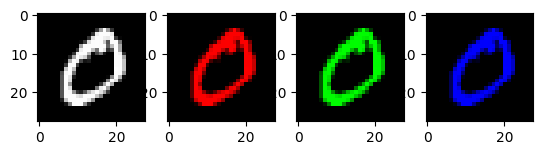

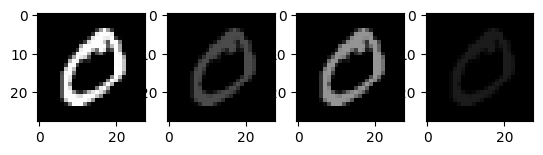

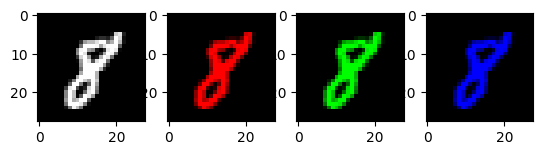

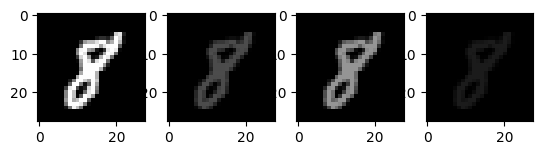

In [4]:
vis_colored(zeros[0])
vis_greyscale(zeros[0])
vis_colored(eights[0])
vis_greyscale(eights[0])

In [5]:
splits = gen_colored_splits(zeros, eights)

Let's evaluate the performance on the same type of data.

In [6]:
rfc = RandomForestClassifier()
rfc.fit(*splits["train"])

X_val, y_val = splits["val"]
preds_val = rfc.predict_proba(X_val)[:, 1]

print(f"""
ROC-AUC Val: {roc_auc_score(y_val, preds_val)}
""")


ROC-AUC Val: 1.0



What if our training data does not contain a certain type of observations?


<img src="tutorial-supervised-ood.png" alt="ood" style="width:600px;"/>

It is a data distribution shift. Our model has not encountered novel data, so it cannot make proper decisions.

For example, we can switch colors between 0s and 8s.

In [7]:
X_test, y_test = splits["test"]
preds_test = rfc.predict_proba(X_test)[:, 1]

print(f"""
ROC-AUC Test: {roc_auc_score(y_test, preds_test)}
""")


ROC-AUC Test: 0.08618909644917713



Our model has overfitted to the colors and has not learned anything about shapes.

The fundamental solution is to increase the diversity of the data and ensure that it can generalize to any situation.

In [8]:
X = np.concatenate([splits["train"][0], splits["train_flipped"][0]])
y = np.concatenate([splits["train"][1], splits["train_flipped"][1]])

rfc = RandomForestClassifier()
rfc.fit(X, y)

preds_val = rfc.predict_proba(X_val)[:, 1]
preds_test = rfc.predict_proba(X_test)[:, 1]

print(f"""
ROC-AUC Val: {roc_auc_score(y_val, preds_val)}
ROC-AUC Test: {roc_auc_score(y_test, preds_test)}
""")


ROC-AUC Val: 0.9996288444335226
ROC-AUC Test: 0.9995615841884935



Now it works much better and can even generalize to new colors.

In [9]:
X_blue, y_blue = splits["blue"]
preds_blue = rfc.predict_proba(X_blue)[:, 1]

print(f"""
ROC-AUC Test Blue: {roc_auc_score(y_blue, preds_blue)}
""")


ROC-AUC Test Blue: 0.9987825618672601



## Introducing the Dynamic Component

However, there are limitations to our ability to handle data distribution shifts.

1. It is possible that we have not considered all possible types of observations (e.g., random crops).

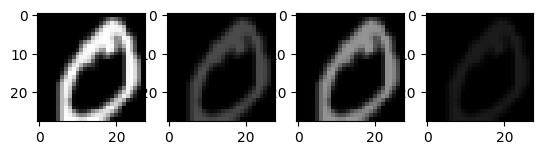

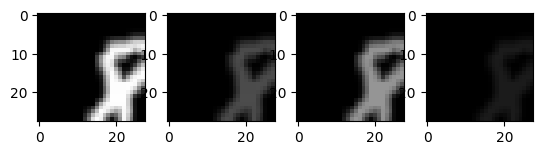

In [10]:
vis_greyscale(rotated_zeros[0])
vis_greyscale(rotated_eights[0])

In [11]:
X, y = gen_sample(rotated_zeros, rotated_eights)

preds_rotated = rfc.predict_proba(X)[:, 1]

print(f"""
ROC-AUC Test Blue: {roc_auc_score(y, preds_rotated)}
""")


ROC-AUC Test Blue: 0.8250072506585036



2. Novel shifts can emerge over time.

For instance, a model's performance may initially be excellent but gradually decline over time due to changes in feature distributions.

Consider a specific example of a time-series forecasting problem: predicting relative changes in electricity consumption for a given household. We have trained a model that demonstrates low error on the validation set, but when tested, the error explodes.

<img src="loss-dynamics.png" alt="mse" style="width:800px;"/>

This phenomenon is widespread across various domains:

1. Images: Features evolution, the emergence of new cameras, and more.
2. Recommendation systems: Introduction of new content, trends, and fashion.
3. Texts: Introduction of novel words and linguistic shifts.
4. Financial data: Business cycles and market fluctuations.
5. Telemetry: Continuous data streams and changing patterns.

<img src="https://raw.githubusercontent.com/huaxiuyao/Wild-Time/main/data_description.png" alt="sl" style="width:800px;"/>

_Credits: Yao, Huaxiu, et al. "Wild-time: A benchmark of in-the-wild distribution shift over time." Advances in Neural Information Processing Systems 35 (2022): 10309-10324._


The common approach to handle this problem is by adapting to the novel data through techniques such as retraining, fine-tuning the model, or employing online learning. It is also crucial to conduct extensive monitoring to respond at the right moment. However, there are sensitive domains where even minor shifts can have significant consequences. Models that heavily rely on data may encounter challenges when data availability is limited. Furthermore, complex models or time-consuming update procedures can hinder prompt adaptation to distribution shifts.

Hence, it is essential to assess model stability and estimate potential performance decline to effectively manage risks associated with distribution shifts. By predicting the possible decline in model performance, we can estimate the financial impact of distribution shifts and allocate resources accordingly.

## Okay, let's see how it looks with real data.

We will work with the [Electricity Transformer Dataset (ETDataset)](https://github.com/zhouhaoyi/ETDataset/).

ETDataset is a collection of time series data that contains the energy consumption information of various transformers. The dataset contains multivariate time series data of the useful and useless loads of high and low-voltage transformers, recorded at different times. It is used for tasks such as time series forecasting, multivariate time series forecasting, and univariate time series forecasting. The dataset has been utilized in various studies, including one that compared the performance of linear models and transformer models.

It contains the following columns

- **date**: The recorded date.
- **HUFL**: High UseFul Load.
- **HULL**: High UseLess Load.
- **MUFL**: Middle UseFul Load.
- **MULL**: Middle UseLess Load.
- **LUFL**: Low UseFul Load.
- **LULL**: Low UseLess Load.
- **OT**: Oil Temperature (target).

Additionally, we include simple features generated from time, such as the day of the month (dom), day of the week (dom), hour, and month (mnth). We also incorporate a lag of the target variable as a feature.

In [12]:
import pandas as pd
import numpy as np
from ectutorial.data import get_ett_dataset

pd.options.display.max_columns = 22
ett = get_ett_dataset(with_features=True)
ett.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,dom,dow,hour,mnth,OT-1
date,,,,,,,,,,,,
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1,4,1,7,30.531000
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,1,4,2,7,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,1,4,3,7,27.787001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,1,4,4,7,25.044001
2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000,1,4,5,7,21.948000


We will split the data based on time into training, validation, and test sets.

In [13]:
val_thresh = int(ett.shape[0] * 0.7)
test_thresh = int(ett.shape[0] * 0.85)

train_data = ett.iloc[:val_thresh].copy()
val_data = ett.iloc[val_thresh:test_thresh].copy()
test_data = ett.iloc[test_thresh:].copy()

## Dataset shift visualization

We can observe differences in the distribution between the training and test sets for almost all variables in the dataset.

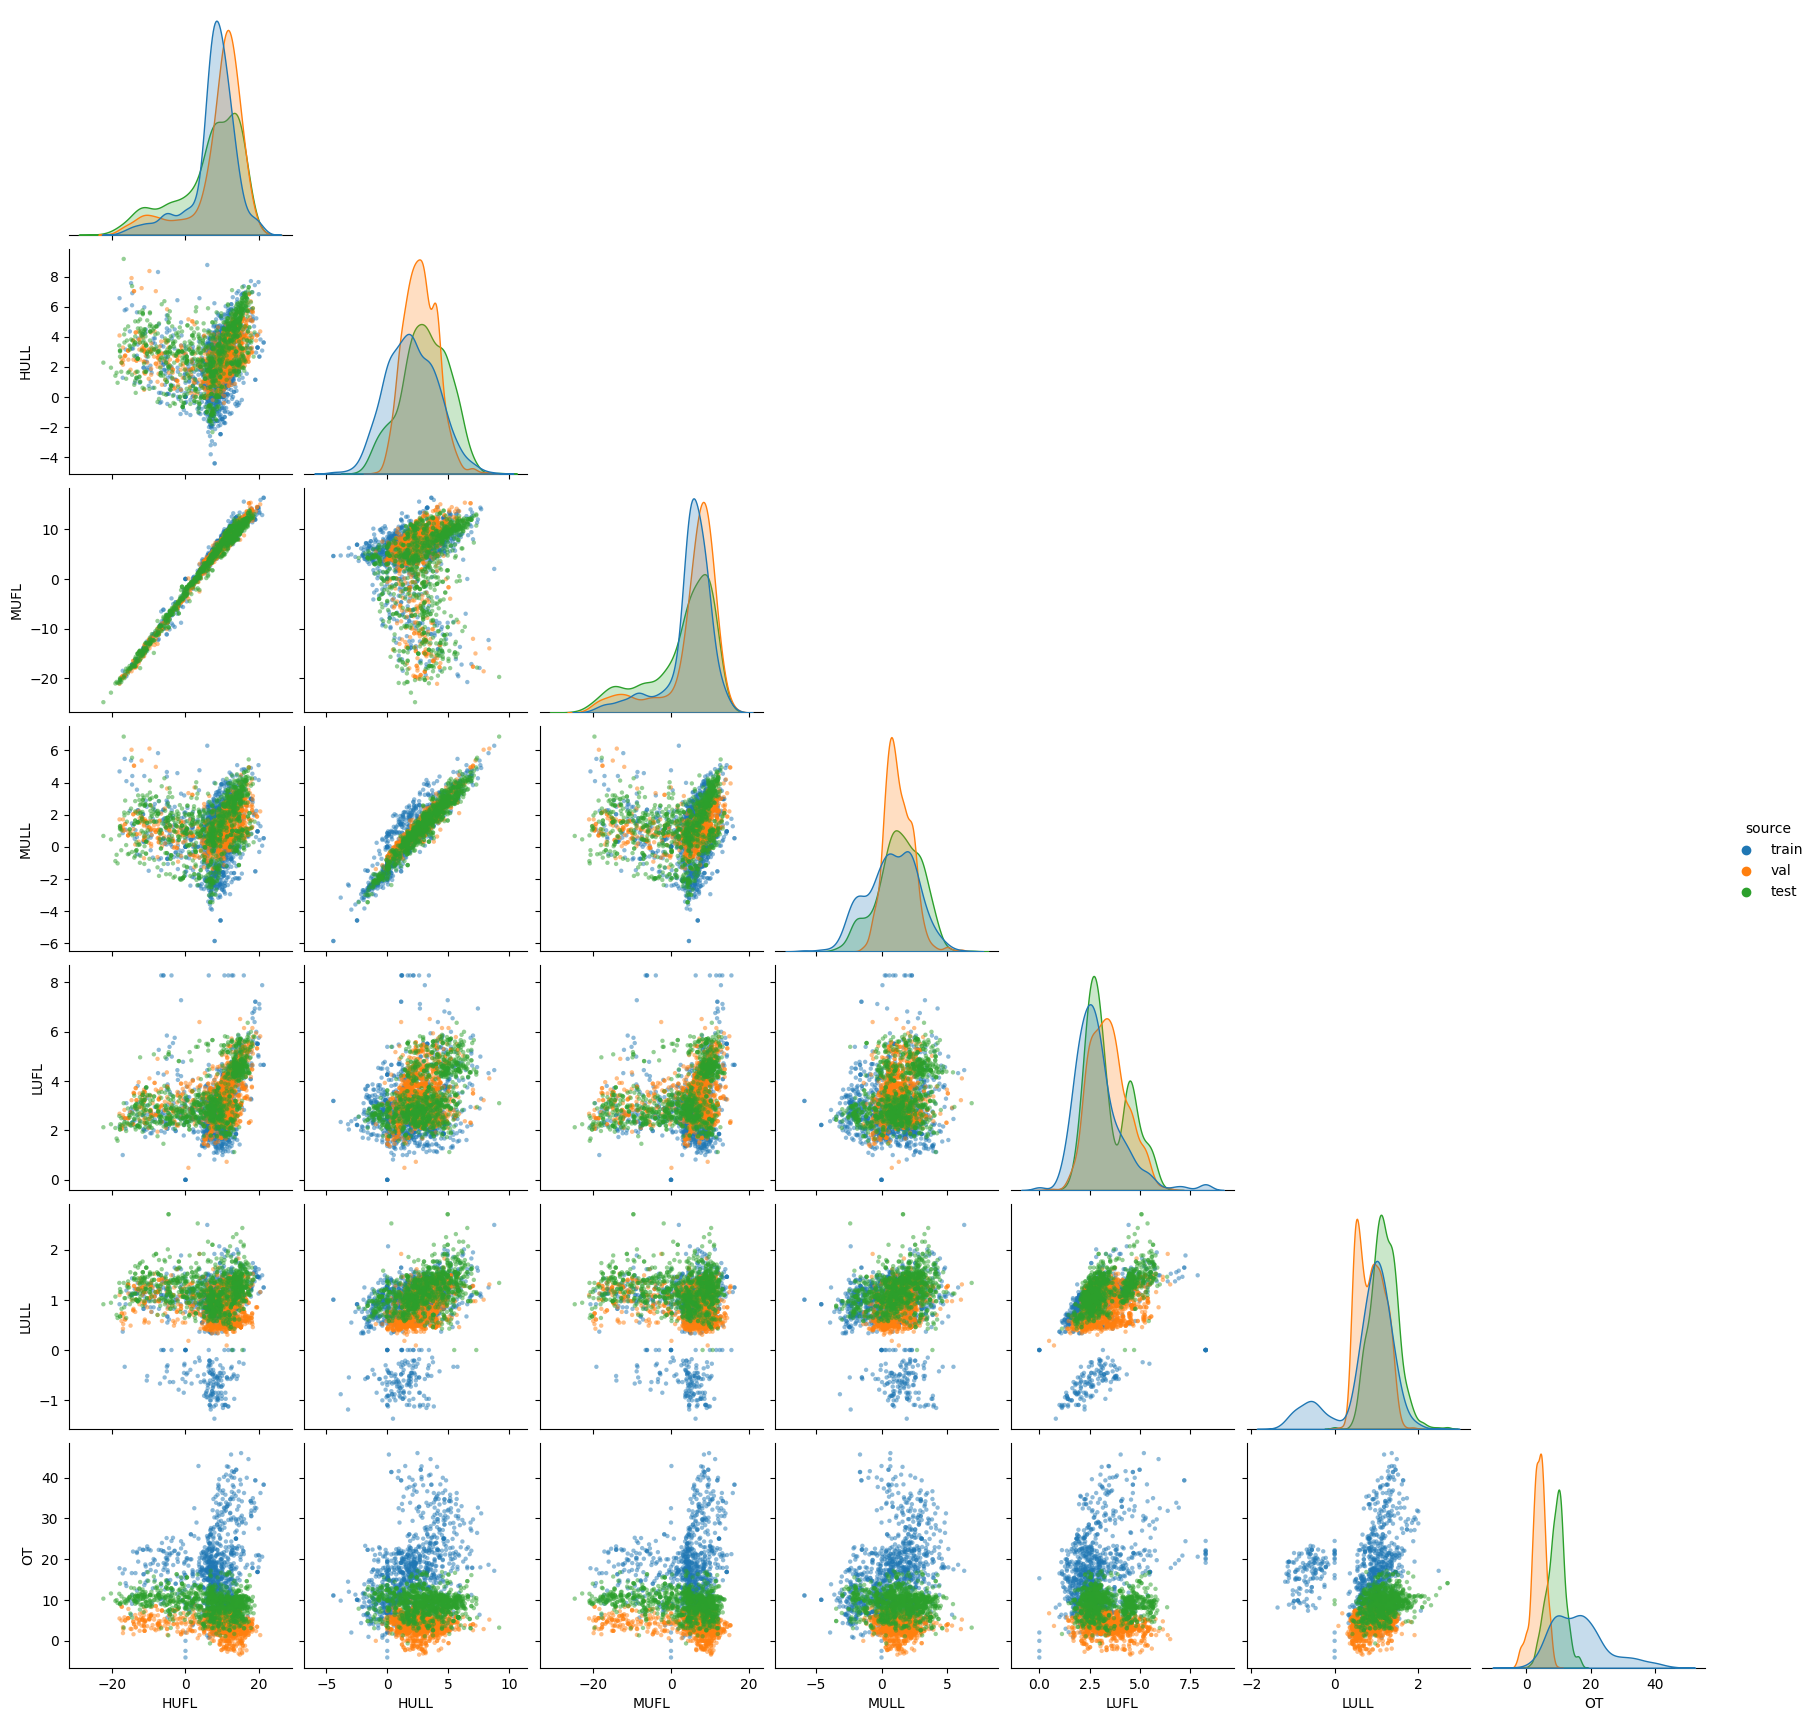

In [14]:
original_columns = ett.columns[:7].tolist()

_train_plot = train_data[original_columns].iloc[np.random.randint(len(train_data), size=1000)].copy()
_train_plot['source'] = 'train'
_val_plot = val_data[original_columns].iloc[np.random.randint(len(val_data), size=1000)].copy()
_val_plot['source'] = 'val'
_test_plot = test_data[original_columns].iloc[np.random.randint(len(test_data), size=1000)].copy()
_test_plot['source'] = 'test'

import seaborn as sns
sns.pairplot(
    pd.concat([_train_plot, _val_plot, _test_plot]), 
    hue='source', 
    corner=True,
    plot_kws={'edgecolor': 'none', 'alpha': 0.5, "s": 10},
);


## Lets build simple model

In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(train_data.drop("OT", axis=1), train_data.OT)

preds_val = lr.predict(val_data.drop("OT", axis=1))
preds_test = lr.predict(test_data.drop("OT", axis=1))

err_val = (val_data.OT - preds_val) ** 2
err_test = (test_data.OT - preds_test) ** 2


print(f"""
RMSE Val: {np.sqrt(err_val.mean()):.2f}
RMSE Test: {np.sqrt(err_test.mean()):.2f}
""")


RMSE Val: 0.62
RMSE Test: 0.67



We experienced a slight drop in the test results due to shifts in the input data.

## How we can estimate the possible fall?

The __worst-case risk__ refers to the highest possible predictive error that a model could make when faced with a worst-case scenario shift in the underlying data distribution. The worst-case risk is important to consider when evaluating a model's robustness to dataset shift because it represents the upper bound of the model's performance and can highlight potential weaknesses or vulnerabilities in the model. A model that performs well under worst-case scenarios is deemed to be more robust and reliable.

<img src="wcr.png" alt="wcr" style="width:800px;"/>

_Credits: Subbaswamy, Adarsh, Roy Adams, and Suchi Saria. "Evaluating model
    robustness and stability to dataset shift." International Conference on Artificial
    Intelligence and Statistics. PMLR, 2021._

In [16]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


def ReLU(x):
    return x * (x > 0)

def worst_case_risk(mu, eta, alpha, h, losses):
    return ReLU(mu-eta) / (1-alpha) + eta + h * (losses-mu) / (1-alpha)

class ConditionalShiftRisk:
    '''
    Based on Subbaswamy, Adarsh, Roy Adams, and Suchi Saria. "Evaluating model
    robustness and stability to dataset shift." International Conference on Artificial
    Intelligence and Statistics. PMLR, 2021.
    '''
    def __init__(self, alpha, cv, loss_model=None, quantile_model=None):
        self.quantile_model = quantile_model
        self.loss_model = loss_model
        self.alpha = alpha
        self.cv = cv
        if loss_model is None:
            self.loss_model = GradientBoostingRegressor()
        if quantile_model is None:
            self.quantile_model = GradientBoostingRegressor(loss='quantile', alpha=alpha)

    def fit(self, X_val, mutable_columns, immutable_columns, losses):
        _val = X_val[mutable_columns + immutable_columns]
        self.h = np.zeros_like(losses).astype('bool')
        self.eta = np.zeros_like(losses)
        self.mu = np.zeros_like(losses)
        for train, test in tqdm(KFold(n_splits=self.cv).split(_val), total=self.cv):
            self.loss_model.fit(_val.iloc[train], losses.iloc[train])
            mu_train = self.loss_model.predict(_val.iloc[train])
            mu_test = self.loss_model.predict(_val.iloc[test])
            self.mu[test] = mu_test
            self.quantile_model.fit(_val.iloc[train][immutable_columns], mu_train)
            eta_test = self.quantile_model.predict(_val.iloc[test][immutable_columns])
            self.eta[test] = eta_test
            self.h[test] = mu_test > eta_test
        risk = worst_case_risk(self.mu, self.eta, self.alpha, self.h, losses)
        self.risk = risk.mean()
        self.ub_risk = self.risk + 1.96 * risk.std() / np.sqrt(losses.shape[0])
        self.lb_risk = self.risk - 1.96 * risk.std() / np.sqrt(losses.shape[0])

We will use features generated from time as immutable because we know it in advance. The rest features may drift over time.

In [17]:
from tqdm import tqdm

immutable = [
    'hour',
    'mnth',
    'dow',
    'dom',
]
mutable = [
    'MUFL',
    'HUFL',
    'HULL',
    'OT-1',
    'MULL',
    'LULL',
    'LUFL'
]

mn_log = []
lb_log = []
ub_log = []

for i in range(9):
    alpha = (i + 1) / 10
    shift_model = ConditionalShiftRisk(
      alpha=alpha,
      cv=5,
      loss_model=LinearRegression(),
      quantile_model=GradientBoostingRegressor(loss='quantile', alpha=alpha),
    )


    losses = pd.Series(err_val)

    shift_model.fit(
      val_data,
      mutable,
      immutable,
      losses,
    )

    mn_log.append(shift_model.risk)
    lb_log.append(shift_model.lb_risk)
    ub_log.append(shift_model.ub_risk)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


And we can visualize the results

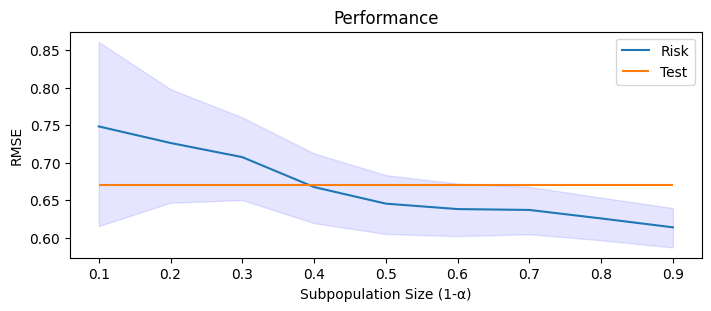

In [18]:
plt.figure(figsize=(7, 3), layout='constrained')
plt.plot(1 - np.arange(1, 10) / 10, [np.sqrt(i) for i in mn_log], label='Risk')
plt.fill_between(1-np.arange(1, 10) / 10, [np.sqrt(i) for i in lb_log], [np.sqrt(i) for i in ub_log], color='b', alpha=.1)
plt.hlines([np.sqrt(err_test.mean())], xmin=0.1, xmax=0.9, color="C1", label='Test')

plt.xlabel('Subpopulation Size (1-α)')
plt.ylabel("RMSE")
# plt.ylim(ymin = 0)
plt.title("Performance")
plt.legend()

## Drawbacks

However, worst-case risks work with the original validation data.

Worst-case scenarios are often extreme and unrealistic, and they may not reflect the full range of possible dataset shifts that a model could face in real-world applications. This limitation could restrict the use of worst-case risk estimates for evaluating model robustness and stability.

Furthermore, real-world time series data often exhibit short ranges and infrequent occurrences. As a result, there is a scarcity of training and validation data, which further widens the confidence interval of estimations.

# See you soon at 12 pm ET

We will discuss how to fix the drawbacks using generative models